Optimization terminated successfully.
         Current function value: 0.541811
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     RSAW remission criteria   No. Observations:                   86
Model:                               Logit   Df Residuals:                       80
Method:                                MLE   Df Model:                            5
Date:                     Sat, 12 Apr 2025   Pseudo R-squ.:                  0.1414
Time:                             19:32:30   Log-Likelihood:                -46.596
converged:                            True   LL-Null:                       -54.266
Covariance Type:                 nonrobust   LLR p-value:                  0.008999
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         

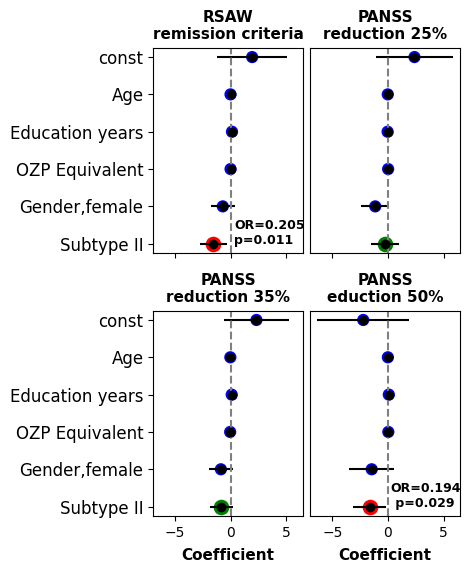

Odds Ratios and Confidence Intervals for RSAW remission criteria:
                       OR      2.5%     97.5%
const            6.848966 -1.237791  5.085987
Age              0.979860 -0.078782  0.038091
Education years  1.119706 -0.033305  0.259437
OZP Equivalent   0.983624 -0.092744  0.059721
Gender,female    0.488314 -1.797073  0.363480
Subtype II       0.204818 -2.807480 -0.363783

Odds Ratios and Confidence Intervals for PANSS reduction 25%:
                        OR      2.5%     97.5%
const            10.924108 -1.088857  5.870801
Age               0.991185 -0.073518  0.055809
Education years   0.976927 -0.166929  0.120242
OZP Equivalent    1.023359 -0.071180  0.117361
Gender,female     0.321463 -2.415398  0.145653
Subtype II        0.786772 -1.515106  1.035473

Odds Ratios and Confidence Intervals for PANSS reduction 35%:
                        OR      2.5%     97.5%
const            10.075494 -0.599222  5.219434
Age               0.963923 -0.092404  0.018916
Education years 

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
df = pd.read_excel('data.xlsx')

def fit_logistic_regression(df, group_column, control_vars):
    # 过滤数据，提取Label中0和1
    df_filtered = df[df['Label'].isin([0, 1])].copy()

    # 转换Group变量（缓解为1，未缓解为0）
    df_filtered[group_column] = df_filtered[group_column].map({1: 1, 2: 0})

    # 将亚组（Label）作为自变量
    df_filtered['Subgroup'] = df_filtered['Label']

    # 对分类变量生成哑变量，包括亚组变量
    df_filtered = pd.get_dummies(df_filtered, columns=['Gender', 'Subgroup'], drop_first=True)

    # 自变量（包括 Dose Equivalent to Olanzapine）
    X = df_filtered[[col for col in df_filtered.columns if col in control_vars or col.startswith(('Gender_', 'Subgroup_'))]]

    # 因变量
    y = df_filtered[group_column]

    # 添加常数项
    X = sm.add_constant(X)

    # 拟合逻辑回归模型
    model = sm.Logit(y, X)
    result = model.fit()

    # 输出模型摘要
    print(result.summary())

    # 计算系数、置信区间和 OR
    coef = result.params
    conf = result.conf_int()
    conf['coef'] = coef
    conf.columns = ['2.5%', '97.5%', 'coef']
    
    odds_ratios = np.exp(result.params)
    conf['OR'] = odds_ratios
    
    return conf, result

def plot_combined_coefficients(conf_list, labels, annotations, suptitle):
    # 创建变量名映射字典
    variable_names = {
        'Education_years': 'Education years',
        'Gender_2': 'Gender,female',
        'Subgroup_1': 'Subtype II',
        'Dose Equivalent to Olanzapine': 'OZP Equivalent'
    }
    
    # 以第二个模型的变量名称为准构建Y轴标签
    y_labels = [variable_names.get(var, var) for var in conf_list[1].index]
    
    # 创建子图 - 2行2列布局，但共享Y轴
    fig, axes = plt.subplots(2, 2, figsize=(4.8, 6.5), sharex=True)
    
    for i, (conf, label, annotation) in enumerate(zip(conf_list, labels, annotations)):
        # 计算当前子图的行和列索引
        row = i // 2
        col = i % 2
        
        # 更新所有图的Y轴变量为第二张图的Y轴变量
        conf.index = y_labels
        
        # 绘制点图
        sns.pointplot(x='coef', y=conf.index, data=conf, join=False, markers='o', color='blue', ax=axes[row, col])
        axes[row, col].errorbar(x=conf['coef'], y=conf.index, 
                         xerr=[conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']], 
                         fmt='o', color='black')
        axes[row, col].axvline(0, color='gray', linestyle='--')
        
        # 使用 set_title 设置标题
        title = axes[row, col].set_title(label, fontsize=11, fontweight='bold')
        title.set_position([0.5, 0.95])
        
        # 只在第二列（索引为1）隐藏Y轴标签和刻度
        if col == 1:
            axes[row, col].set_yticks([])
            axes[row, col].set_ylabel('')
        else:
            # 第一列显示Y轴标签
            axes[row, col].tick_params(axis='y', labelsize=12)
        
        # 只在底部行显示X轴标签
        if row < 1:  # 不是底部行
            axes[row, col].set_xlabel('')
        else:  # 底部行
            axes[row, col].set_xlabel('Coefficient', fontsize=11, fontweight='bold', labelpad=6)

        # 高亮显示 Subgroup（Subtype）变量，并放置注释文本
        for var in conf.index:
            if 'Subtype' in var:
                color = 'red' if (conf.loc[var, '2.5%'] > 0 or conf.loc[var, '97.5%'] < 0) else 'green'
                axes[row, col].scatter(conf.loc[var, 'coef'], var, color=color, s=150, edgecolor='white')
                if color == 'red':
                    axes[row, col].text(
                        conf.loc[var, 'coef'] + 1.9,
                        var, 
                        annotation,
                        fontsize=9,
                        color='black', 
                        rotation=0, 
                        fontweight='bold'
                    )
    
    # 添加总标题并调整位置
    fig.suptitle(suptitle, fontsize=14, fontweight='bold', x=0.5, y=0.95, ha='center', va='top')

    # 调整子图间距，左侧留更多空间给Y轴标签
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.subplots_adjust(wspace=0.05)  # 减小水平间距，因为右列不需要Y轴标签空间
    
    # 保存图像
    plt.savefig('combined_coef_plot.jpg', dpi=1200, bbox_inches='tight')
    plt.show()

# 定义需要控制的变量
control_vars = ['Age', 'Education_years', 'Gender', 'Dose Equivalent to Olanzapine']

# 计算四个不同条件下的logistic回归模型系数
conf1, result1 = fit_logistic_regression(df, 'RSAW remission criteria', control_vars)
conf2, result2 = fit_logistic_regression(df, 'PANSS duction 0.25', control_vars)  # 新增加的条件
conf3, result3 = fit_logistic_regression(df, 'PANSS duction 0.35', control_vars)
conf4, result4 = fit_logistic_regression(df, 'PANSS duction 0.50', control_vars)

# 定义每个图的注释内容
annotations = [
    'OR=0.205\np=0.011',  # RSAW的注释
    'OR=0.787\np=0.712',  # PANSS 0.25的注释
    'OR=0.434\np=0.108',  # PANSS 0.35的注释
    'OR=0.194\n p=0.029'   # PANSS 0.50的注释
]

# 绘制组合图
plot_combined_coefficients([conf1, conf2, conf3, conf4], 
                           ['RSAW\nremission criteria', 'PANSS\nreduction 25%', 'PANSS\nreduction 35%', 'PANSS\neduction 50%'], 
                           annotations, suptitle='')

# 打印odds ratios和置信区间
print("Odds Ratios and Confidence Intervals for RSAW remission criteria:")
print(conf1[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 25%:")
print(conf2[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 35%:")
print(conf3[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 50%:")
print(conf4[['OR', '2.5%', '97.5%']])